In [34]:
import os
import random
from collections import Counter
try:
    import cPickle as pickle
except ImportError:
    import pickle
import gc

from gensim.models import KeyedVectors
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import numpy as np
import pandas
from pandas import Series, DataFrame

from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import seaborn as sns       

from scipy import stats
from scipy.stats import  norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [42]:
original_base_dir = "./data_sets/original_data/"

train_text_path = os.path.join(original_base_dir, "train.txt")
train_label_path = os.path.join(original_base_dir, "train_label.txt")
valid_text_path = os.path.join(original_base_dir, "valid.txt")
valid_label_path = os.path.join(original_base_dir, "valid_label.txt")
test_text_path = os.path.join(original_base_dir, "test.txt")
test_label_path = os.path.join(original_base_dir, "test_label.txt")

train_path = "./data_sets/train.txt"
dev_path = "./data_sets/dev.txt"
test_path = "./data_sets/test.txt"
all_data = os.path.join(original_base_dir, "all.txt")
word2vec_path = "./data_sets/word2vec.txt"
char_dict_path = os.path.join(original_base_dir, "maps.pkl")

ccks_2018_file = os.path.join(original_base_dir, "ccks2018_all_data.txt")

embedding_dim = 128

In [44]:
def load_data(fpath):
    with open(fpath, 'r', encoding="utf-8") as fr:
        data = [line.strip() for line in fr.readlines()]
    return data

def merge_text_label(texts, labels):
    all_data = []
    for i in range(len(texts)):
        temp = []
        text_list = texts[i].split()
        label_list = labels[i].split()
        for j in range(len(text_list)):
            temp.append([text_list[j], label_list[j]])
        all_data.append(temp)
    return all_data

def write_train_val_test(data, output_file):
    with open(output_file, "w", encoding="utf-8") as fw:
        for item in data:
            for sent in item:
                fw.write(sent[0] + " " + sent[1] + "\n")
            fw.write("\n")
            
def write_sentences(data, output_file):
    with open(output_file, 'w', encoding="utf-8") as fw:
        for item in data:
            fw.write(item + "\n")

def train_word2vec(data_path, embedding_dim, window_size, min_count, output_path):
    model = Word2Vec(LineSentence(data_path), size=embedding_dim, window=window_size, min_count=min_count, workers=multiprocessing.cpu_count())
    # model.save("./data/type_word2vec.bin")
    model.wv.save_word2vec_format(output_path, binary=False)
            
def load_word2vec(embedding_path, word_index, embed_dim=128): 
    """
    载入预训练好的word2vec(Google-News)
    """
    # 载入word2vec词向量
    word2vec_dict = KeyedVectors.load_word2vec_format(embedding_path,binary=True)
    
    embedding_index = dict()
    for word in word2vec_dict.wv.vocab:
        embedding_index[word] = word2vec_dict.word_vec(word)
    print('Load %s word vectors.' % len(embedding_index))
    
    all_embs = np.stack(list(embedding_index.values()))
    # emb_mean, emb_std = all_embs.mean(), all_embs.std()
    emb_mean = np.mean(all_embs, axis=0)
    vocab_size = len(word_index)
    # 初始化权重
    embedding_matrix = np.zeros((vocab_size+1, embed_dim))
    gc.collect()
    # 对权重矩阵进行赋值，未找到时用词向量平均值填充
    for word, i in word_index.items():
        if i < vocab_size + 1:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                embedding_matrix[i] = emb_mean
    del embedding_index
    return embedding_matrix

def creat_dict(data_path, dict_path):
    dico = dict()
#     dico["<PAD>"] = 0
    dico["<UNK>"] = 1
    all_words = []
    with open(data_path, 'r', encoding="utf-8") as fr:
        for line in fr.readlines():
            line=line.strip().split()
            all_words += line
    all_words = set(all_words)
    i = 2
    for item in all_words:
        dico[item] = i
        i += 1
    print(dico)
    with open(dict_path, 'wb') as fw:
        pickle.dump(dico, fw)

In [45]:
creat_dict(all_data, char_dict_path)

{'<UNK>': 1, '肋': 2, '驾': 3, '堵': 4, '牛': 5, '炼': 6, '厄': 7, '何': 8, '个': 9, '运': 10, '激': 11, '午': 12, '涎': 13, '困': 14, '最': 15, '遂': 16, '果': 17, '桂': 18, '：': 19, '颧': 20, '腹': 21, '窝': 22, 'C': 23, '苦': 24, '阑': 25, '必': 26, '术': 27, '阻': 28, '窍': 29, '躯': 30, '独': 31, '骨': 32, '弃': 33, '失': 34, '拍': 35, '尤': 36, '怒': 37, '仰': 38, '又': 39, '立': 40, '御': 41, '阵': 42, '绀': 43, '焊': 44, '收': 45, '别': 46, '框': 47, '我': 48, '之': 49, '苯': 50, '塔': 51, '唇': 52, '肉': 53, '试': 54, '网': 55, '５': 56, '⑤': 57, '游': 58, '鲜': 59, '宗': 60, '天': 61, '敖': 62, '浮': 63, '速': 64, 'W': 65, '紊': 66, '江': 67, '功': 68, '鹿': 69, '持': 70, '金': 71, '哈': 72, '碍': 73, '弓': 74, 'f': 75, '抑': 76, '芳': 77, '弱': 78, '退': 79, '想': 80, '部': 81, '滑': 82, '旁': 83, '敏': 84, '骼': 85, '挤': 86, '扑': 87, '创': 88, '液': 89, '龈': 90, '桃': 91, 'c': 92, '折': 93, '慎': 94, '剑': 95, '拟': 96, '李': 97, '拿': 98, '＋': 99, '处': 100, '筛': 101, '影': 102, '简': 103, '嗜': 104, '村': 105, '均': 106, '送': 107, '绒': 108, '县': 109, '菲': 110, '露'

In [38]:
train_text = load_data(train_text_path)
train_label = load_data(train_label_path)
train_data = merge_text_label(train_text, train_label)
write_train_val_test(train_data, train_path)

dev_text = load_data(valid_text_path)
dev_label = load_data(valid_label_path)
dev_data = merge_text_label(dev_text, dev_label)
write_train_val_test(dev_data, dev_path)

test_text = load_data(test_text_path)
test_label = load_data(test_label_path)
test_data = merge_text_label(test_text, test_label)
write_train_val_test(test_data, test_path)

ccks2018_text = load_data(ccks_2018_file)
    
all_text = train_text + dev_text + test_text + ccks2018_text
write_sentences(all_text, all_data)

all_text_length = [len(line.split()) for line in all_text]

train_word2vec(all_data, embedding_dim, 5, 1, word2vec_path)

In [39]:
# list to series
ser = Series(all_text_length)
ser.describe()

count    11221.000000
mean        45.256305
std         40.276260
min          1.000000
25%         18.000000
50%         33.000000
75%         59.000000
max        612.000000
dtype: float64

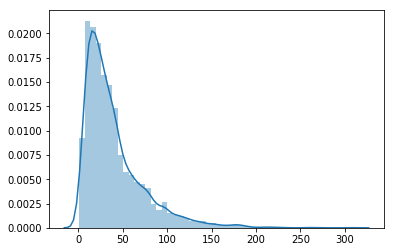

In [31]:
sns.distplot(ser)

In [40]:
def load_word2vec(emb_path, id_to_word, word_dim, old_weights):
    """
    Load word embedding from pre-trained file
    embedding size must match
    """
    new_weights = old_weights
    print('Loading pretrained embeddings from {}...'.format(emb_path))
    pre_trained = {}
    emb_invalid = 0
    for i, line in enumerate(codecs.open(emb_path, 'r', 'utf-8')):
        line = line.rstrip().split()
        if len(line) == word_dim + 1:
            pre_trained[line[0]] = np.array(
                [float(x) for x in line[1:]]
            ).astype(np.float32)
        else:
            emb_invalid += 1
    if emb_invalid > 0:
        print('WARNING: %i invalid lines' % emb_invalid)
    c_found = 0
    c_lower = 0
    c_zeros = 0
    n_words = len(id_to_word)
    # Lookup table initialization
    for i in range(n_words):
        word = id_to_word[i]
        if word in pre_trained:
            new_weights[i] = pre_trained[word]
            c_found += 1
        elif word.lower() in pre_trained:
            new_weights[i] = pre_trained[word.lower()]
            c_lower += 1
        elif re.sub('\d', '0', word.lower()) in pre_trained:
            new_weights[i] = pre_trained[
                re.sub('\d', '0', word.lower())
            ]
            c_zeros += 1
    print('Loaded %i pretrained embeddings.' % len(pre_trained))
    print('%i / %i (%.4f%%) words have been initialized with '
          'pretrained embeddings.' % (
        c_found + c_lower + c_zeros, n_words,
        100. * (c_found + c_lower + c_zeros) / n_words)
    )
    print('%i found directly, %i after lowercasing, '
          '%i after lowercasing + zero.' % (
        c_found, c_lower, c_zeros
    ))
    return new_weights